In [1]:
%cd /users/anglos/Developer/psiphi

/auto/users/anglos/Developer/psiphi


In [2]:
#@title Imports
import jax
import tree

import social_rl

In [3]:
#@title Constants, experiment config.
GOAL_COLOR = 'blue'
NUM_LEARNING_STEPS = 1_500
BATCH_SIZE = 128
DATA_DIR = 'data'
EXPERT_EPSILON = 0.05

In [4]:
#@title Collect expert data: Run this only once!
if True:
  !rm -rf data/{GOAL_COLOR}/{EXPERT_EPSILON}
  !/scratch/anglos/conda_envs/psiphi/bin/python experiments/collect_rollouts.py \
    -config=experiments/configs/collect_rollouts.py:{GOAL_COLOR} \
    --config.num_rollouts=250 \
    --config.epsilon={EXPERT_EPSILON}

I1026 13:36:32.621764 140435178207040 collect_rollouts.py:36] ['experiments/collect_rollouts.py']
I1026 13:36:32.621861 140435178207040 collect_rollouts.py:37] 
experiments/collect_rollouts.py:
  --config: path to config file.
    (default: 'None')

absl.app:
  -?,--[no]help: show this help
    (default: 'false')
  --[no]helpfull: show full help
    (default: 'false')
  --[no]helpshort: show this help
    (default: 'false')
  --[no]helpxml: like --helpfull, but generates XML output
    (default: 'false')
  --[no]only_check_args: Set to true to validate args and exit.
    (default: 'false')
  --[no]pdb: Alias for --pdb_post_mortem.
    (default: 'false')
  --[no]pdb_post_mortem: Set to true to handle uncaught exceptions with PDB post
    mortem.
    (default: 'false')
  --profile_file: Dump profile information to a file (for python -m pstats).
    Implies --run_with_profiling.
  --[no]run_with_pdb: Set to true for PDB debug mode
    (default: 'false')
  --[no]run_with_profiling: Set to 

In [5]:
#@title Initialise environment, agent and offline dataset.
env = social_rl.GridWorld(goal_color=GOAL_COLOR)
replay_buffer = social_rl.replay.DemonstrationsBuffer(
    batch_size=BATCH_SIZE,
    data_dir='{}/{}/{}'.format(DATA_DIR, GOAL_COLOR, EXPERT_EPSILON),
    seed=42)
for evaluation in (True, False):
  assert replay_buffer.can_sample(evaluation)
agent = social_rl.agents.BCAgent(env)

100%|██████████| 250/250 [00:00<00:00, 369.83it/s]


100%|██████████| 1500/1500 [00:05<00:00, 252.26it/s]


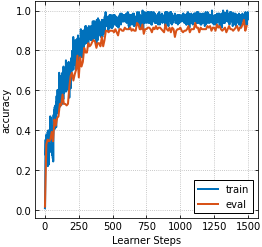

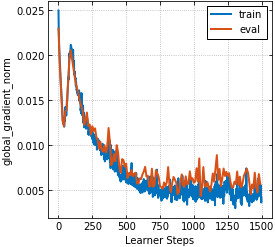

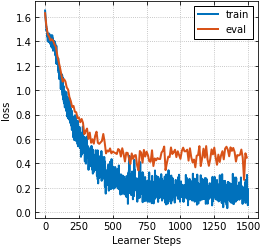

In [6]:
#@title Train agent on offline dataset.
learner_buffer_loop = social_rl.loops.LearnerBufferLoop([replay_buffer], agent)
rng_key = jax.random.PRNGKey(42)
rng_key, learner_key = jax.random.split(rng_key, num=2)
params, learner_state, learner_stats = learner_buffer_loop.run(
    learner_key, num_iterations=NUM_LEARNING_STEPS, evaluate_every=10)
social_rl.plotting.plot_learner_buffer_loop_stats(learner_stats);

In [7]:
#@title Evaluate agent online.
def evaluate(env: social_rl.GridWorld) -> float:
  """Return the success rate on `env`."""
  actor_env_loop = social_rl.loops.ActorEnvironmentLoop(env, agent)
  _, actor_stats = actor_env_loop.run(
    jax.random.PRNGKey(13), num_iterations=500, params=params, evaluation=True)
  return actor_stats['returns'].sum() / len(actor_stats['returns'])

environments = {
    goal_color: social_rl.GridWorld(goal_color=goal_color, seed=42)
    for goal_color in ('red', 'green', 'blue')
}
tree.map_structure(evaluate, environments)

  0%|          | 0/500 [00:00<?, ?it/s]/scratch/anglos/conda_envs/psiphi/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:5940: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
100%|██████████| 500/500 [00:00<00:00, 748.43it/s]


{'red': -1.0, 'green': -1.0, 'blue': 1.0}